In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms
from tqdm import tqdm

"""

[Impl: Dataloader] If the image is with high resolution, it might be not feasible train the network with the all the pixels in every iteration due to the GPU memory limit. So you need to implement a dataloader that randomly sample
N pixels at every iteration for training. The dataloader is expected to return both the Nx2 2D coordinates and Nx3 colors of the pixels, which will serve as the input to your network, and the supervision target, respectively (essentially you have a batch size of N). You would want to normalize both the coordinates (x = x / image_width, y = y / image_height) and the colors (rgbs = rgbs / 255.0) to make them within the range of [0, 1].

"""
class ImageDataset(Dataset):
    def __init__(self, image_path):
        self.image = Image.open(image_path).convert('RGB')
        self.transform = transforms.ToTensor()
        self.width, self.height = self.image.size
        self.pixels = np.array(self.image)

    def __len__(self):
        return self.width * self.height

    def __getitem__(self, idx):
        x = idx % self.width
        y = idx // self.width
        coord = torch.tensor([x / self.width, y / self.height], dtype=torch.float32)
        color = torch.tensor(self.pixels[y, x] / 255.0, dtype=torch.float32)
        return coord, color

class PositionalEncoding(nn.Module):
    def __init__(self, num_freqs):
        super(PositionalEncoding, self).__init__()
        self.num_freqs = num_freqs

    def forward(self, x):
        pe = [x]
        for i in range(self.num_freqs):
            freq = 2 ** i
            pe.append(torch.sin(freq * x))
            pe.append(torch.cos(freq * x))
        return torch.cat(pe, dim=-1)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, L):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            PositionalEncoding(num_freqs=L),
            nn.Linear(input_dim + 2 * input_dim * L, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

def train(model, dataloader, num_iterations, show_progression=False, show_psnr_curve=False, im_name=None, verbose=False):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    psnr_values = []
    progression_images = []
    for iteration in tqdm(range(num_iterations)):
        coords, colors = next(iter(dataloader))
        coords, colors = coords.to(device), colors.to(device)
        optimizer.zero_grad()
        predicted_colors = model(coords)
        loss = criterion(predicted_colors, colors)
        loss.backward()
        optimizer.step()

        mse = loss.item()
        psnr = 10 * np.log10(1 / mse)
        if iteration % 100 == 0 and verbose:
            print(f'Iteration {iteration}, MSE: {mse:.6f}, PSNR: {psnr:.2f} dB')
        if show_progression:
            step = max(1, num_iterations // 4)
            if iteration % step == 0 or iteration == num_iterations - 1:
                with torch.no_grad():
                    all_coords = torch.tensor([[x / dataloader.dataset.width, y / dataloader.dataset.height]
                                for y in range(dataloader.dataset.height)
                                for x in range(dataloader.dataset.width)], dtype=torch.float32).to(device)
                    predicted_colors = model(all_coords).cpu().numpy()
                    predicted_image = predicted_colors.reshape(dataloader.dataset.height, dataloader.dataset.width, 3)
                progression_images.append((iteration, predicted_image))
        if show_psnr_curve:
            psnr_values.append(psnr)
    if show_progression:
        fig, axes = plt.subplots(1, len(progression_images), figsize=(15, 5))
        for ax, (iteration, img) in zip(axes, progression_images):
            ax.imshow(img)
            ax.set_title(f'Iteration {iteration}')
            ax.axis('off')
        plt.savefig("out/1/" + im_name + "_progressions.png")
        plt.show()
    if show_psnr_curve:
        plt.plot(psnr_values)
        plt.title('PSNR Curve')
        plt.xlabel('Iteration (x100)')
        plt.ylabel('PSNR (dB)')
        plt.savefig("out/1/" + im_name + "_psnr.png")
        plt.show()

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Iteration 0, MSE: 0.100614, PSNR: 9.97 dB


  7%|▋         | 102/1500 [00:16<03:16,  7.11it/s]

Iteration 100, MSE: 0.004584, PSNR: 23.39 dB


 13%|█▎        | 202/1500 [00:31<03:05,  7.00it/s]

Iteration 200, MSE: 0.003853, PSNR: 24.14 dB


 20%|██        | 302/1500 [00:46<02:51,  6.97it/s]

Iteration 300, MSE: 0.003365, PSNR: 24.73 dB


 27%|██▋       | 402/1500 [01:02<02:46,  6.58it/s]

Iteration 400, MSE: 0.003611, PSNR: 24.42 dB


 33%|███▎      | 501/1500 [01:17<02:15,  7.37it/s]

Iteration 500, MSE: 0.002864, PSNR: 25.43 dB


 40%|████      | 601/1500 [01:33<02:05,  7.17it/s]

Iteration 600, MSE: 0.002829, PSNR: 25.48 dB


 47%|████▋     | 701/1500 [01:48<01:49,  7.31it/s]

Iteration 700, MSE: 0.002730, PSNR: 25.64 dB


 53%|█████▎    | 801/1500 [02:04<01:36,  7.21it/s]

Iteration 800, MSE: 0.002569, PSNR: 25.90 dB


 60%|██████    | 901/1500 [02:19<01:20,  7.45it/s]

Iteration 900, MSE: 0.002666, PSNR: 25.74 dB


 67%|██████▋   | 1001/1500 [02:35<01:10,  7.08it/s]

Iteration 1000, MSE: 0.002833, PSNR: 25.48 dB


 73%|███████▎  | 1101/1500 [02:50<00:57,  6.99it/s]

Iteration 1100, MSE: 0.002449, PSNR: 26.11 dB


 80%|████████  | 1202/1500 [03:07<00:42,  6.98it/s]

Iteration 1200, MSE: 0.002328, PSNR: 26.33 dB


 87%|████████▋ | 1302/1500 [03:22<00:28,  6.96it/s]

Iteration 1300, MSE: 0.002392, PSNR: 26.21 dB


 93%|█████████▎| 1402/1500 [03:38<00:14,  6.96it/s]

Iteration 1400, MSE: 0.002384, PSNR: 26.23 dB


100%|██████████| 1500/1500 [03:54<00:00,  6.41it/s]


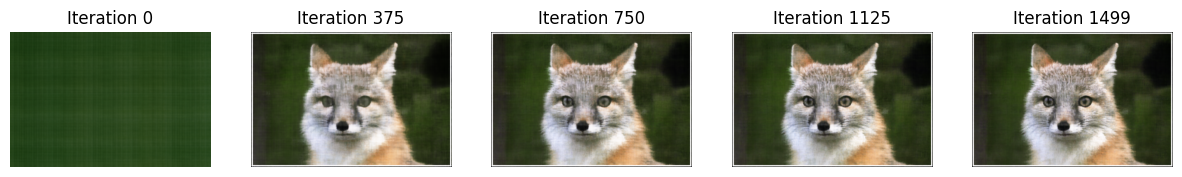

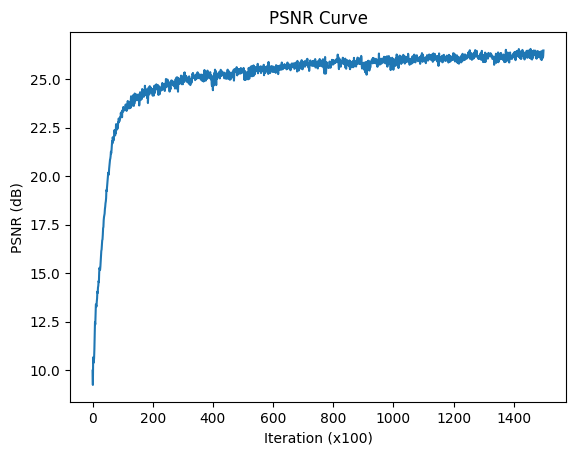

In [27]:
dataset = ImageDataset('data/fox.jpg')
dataloader = DataLoader(dataset, batch_size=10000, shuffle=True)
model = MLP(input_dim=2, hidden_dim=256, output_dim=3, L=10).to(device)

train(model, dataloader, num_iterations=1500, show_progression=True, show_psnr_curve=True, im_name='fox')

100%|██████████| 1000/1000 [02:33<00:00,  6.51it/s]


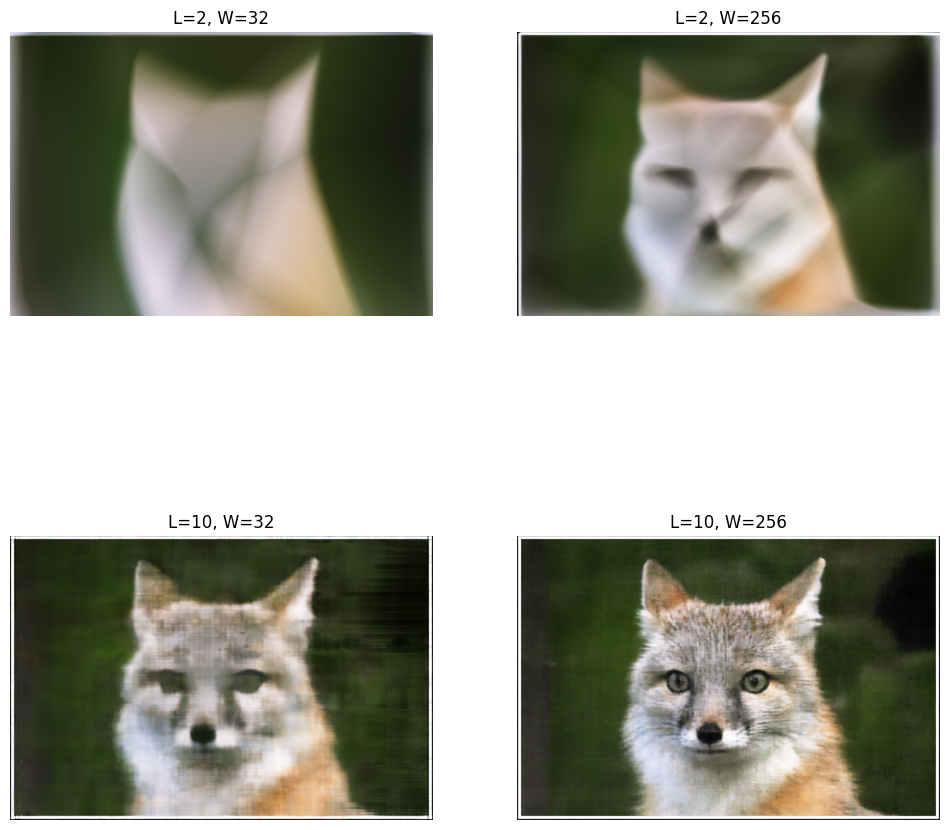

In [30]:
#     Show final results for 2 choices of max positional encoding frequency and 2 choices of width (a 2x2 grid of results). Try very low values for these hyperparameters to see how it affects the outputs.

Ls = [2, 10]
Ws = [32, 256]

plt.subplots(2, 2, figsize=(12, 12))

for L in Ls:
    for W in Ws:
        dataset = ImageDataset('data/fox.jpg')
        dataloader = DataLoader(dataset, batch_size=10000, shuffle=True)
        model = MLP(input_dim=2, hidden_dim=W, output_dim=3, L=L).to(device)
        train(model, dataloader, num_iterations=1000, show_progression=False, show_psnr_curve=False)
        with torch.no_grad():
            all_coords = torch.tensor([[x / dataloader.dataset.width, y / dataloader.dataset.height]
                                        for y in range(dataloader.dataset.height)
                                        for x in range(dataloader.dataset.width)], dtype=torch.float32).to(device)
            predicted_colors = model(all_coords).cpu().numpy()
            predicted_image = predicted_colors.reshape(dataloader.dataset.height, dataloader.dataset.width, 3)
        plt.subplot(2, 2, Ls.index(L) * 2 + Ws.index(W) + 1)
        plt.imshow(predicted_image)
        plt.title(f'L={L}, W={W}')
        plt.axis('off')
plt.show()

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [10:08<00:00,  4.93it/s]


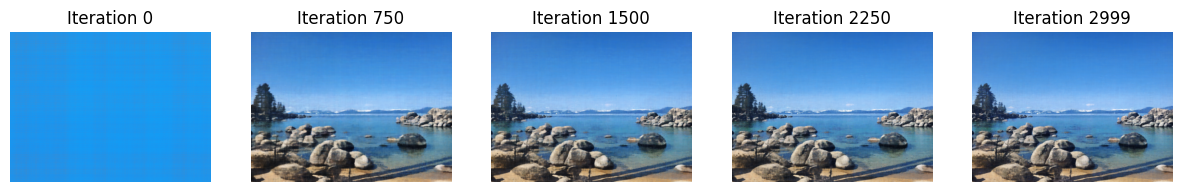

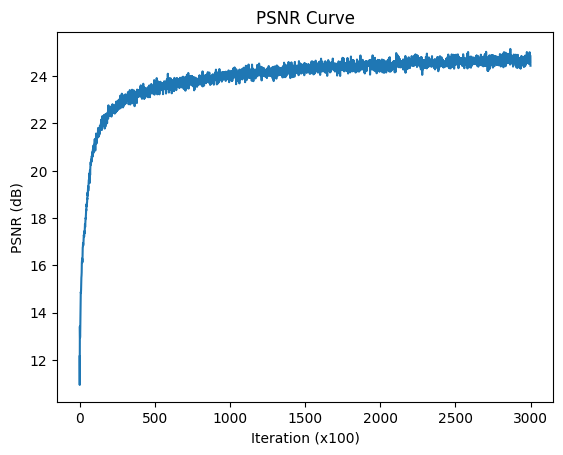

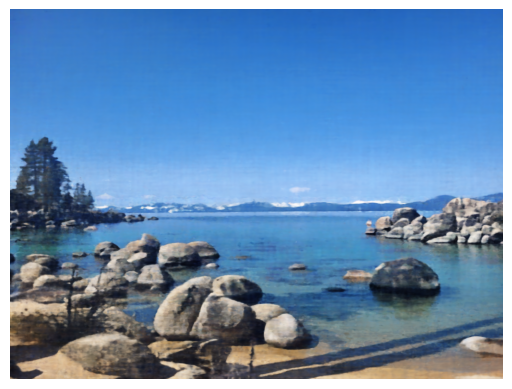

In [ ]:
# Try on your own image
dataset = ImageDataset('data/tahoe.jpg')
dataloader = DataLoader(dataset, batch_size=10000, shuffle=True)
model = MLP(input_dim=2, hidden_dim=256, output_dim=3, L=10).to(device)

train(model, dataloader, num_iterations=3000, show_progression=True, show_psnr_curve=True, im_name='tahoe')

from utils import show_image

with torch.no_grad():
    all_coords = torch.tensor([[x / dataloader.dataset.width, y / dataloader.dataset.height]
                                for y in range(dataloader.dataset.height)
                                for x in range(dataloader.dataset.width)], dtype=torch.float32).to(device)
    predicted_colors = model(all_coords).cpu().numpy()
    predicted_image = predicted_colors.reshape(dataloader.dataset.height, dataloader.dataset.width, 3)

    show_image(predicted_image, "out/1/" + "tahoe" + "_final.png")